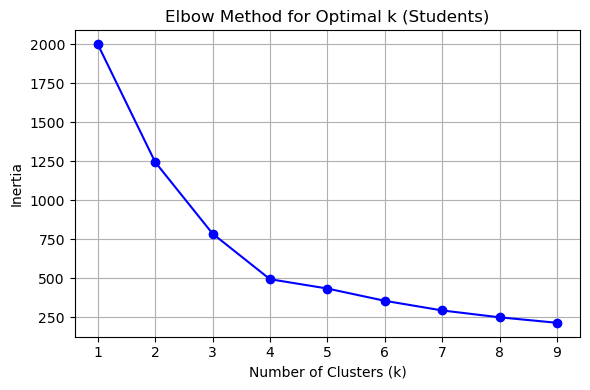

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Interactive map with food filters and clusters saved as 'students_food_filter_map.html'


In [15]:
import pandas as pd
import numpy as np
import folium
from folium import FeatureGroup, LayerControl
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import requests
import matplotlib.pyplot as plt
import time

# ------------------------
# 1. Get Coordinates
# ------------------------
address = 'Thane West, Thane, Maharashtra 400604'
geolocator = Nominatim(user_agent="geo_agent")
location = geolocator.geocode(address)
latitude, longitude = location.latitude, location.longitude

# ------------------------
# 2. Fetch More Nearby Restaurants via Foursquare
# ------------------------
radius, LIMIT, query = 2000, 50, 'food'
headers = {"accept": "application/json", 'Authorization': 'fsq3jeYU7eFqqv4sz4lJfVAHTVUJATaSg3H5IfJYiSt97P8='}
venues = []
offset = 0

while len(venues) < 80:
    api_url = f'https://api.foursquare.com/v3/places/search?ll={latitude},{longitude}&radius={radius}&limit={LIMIT}&offset={offset}&query={query}'
    response = requests.get(api_url, headers=headers)
    if response.status_code != 200:
        print("API Error")
        break
    data = response.json().get("results", [])
    if not data:
        break
    for place in data:
        venues.append({
            'Venue': place['name'],
            'Latitude_of_venue': place['geocodes']['main']['latitude'],
            'Longitude_of_venue': place['geocodes']['main']['longitude'],
            'Category': place['categories'][0]['name'] if place['categories'] else 'Unknown'
        })
    offset += LIMIT
    time.sleep(1)

nearby_venues = pd.DataFrame(venues)

# ------------------------
# 3. Simulate Student Data
# ------------------------
data = pd.DataFrame({
    'student_id': range(1, 1001),
    'Frequency_of_Eating_Out': np.random.randint(1, 10, 1000),
    'Spending_Capacity': np.random.randint(100, 1000, 1000),
    'Food_Preference': np.random.choice(['Veg', 'Non-Veg', 'Vegan'], 1000)
})
data["Latitude"] = latitude + np.random.normal(0, 0.001, size=len(data))
data["Longitude"] = longitude + np.random.normal(0, 0.001, size=len(data))

# Encode preference & scale
data["Food_Preference_Encoded"] = data["Food_Preference"].map({"Veg": 0, "Non-Veg": 1, "Vegan": 2})
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data[["Frequency_of_Eating_Out", "Spending_Capacity"]])

# Remove outliers
Q1, Q3 = np.percentile(features_scaled, 25, axis=0), np.percentile(features_scaled, 75, axis=0)
IQR = Q3 - Q1
mask = ~((features_scaled < (Q1 - 1.5 * IQR)) | (features_scaled > (Q3 + 1.5 * IQR))).any(axis=1)
data_filtered = data[mask].copy()
features_scaled = features_scaled[mask]

# ------------------------
# 4. Determine Optimal k for Student Clustering using Elbow Method
# ------------------------
inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(features_scaled)
    inertias.append(kmeans_test.inertia_)

# Plot elbow chart for students
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Students)')
plt.grid(True)
plt.tight_layout()
plt.savefig("elbow_students.png")
plt.show()

# Apply chosen k (assume 4 from elbow)
kmeans = KMeans(n_clusters=4, random_state=42)
data_filtered["Cluster"] = kmeans.fit_predict(features_scaled)

# ------------------------
# 5. Assign Cluster to Venues by Proximity to Restaurant Centroids
# ------------------------
restaurant_cluster_centroids = []
restaurant_descriptions = {
    0: "Cluster 0: Frequent Eater, Low Budget",
    1: "Cluster 1: Frequent Eater, High Budget",
    2: "Cluster 2: Rare Eater, High Budget",
    3: "Cluster 3: Balanced Eating & Budget"
}

venue_features = np.random.normal(size=(len(nearby_venues), 2))
kmeans_venues = KMeans(n_clusters=4, random_state=42)
kmeans_venues.fit(venue_features)
nearby_venues["Cluster"] = kmeans_venues.predict(venue_features)

for cluster_id in range(4):
    cluster_data = nearby_venues[nearby_venues["Cluster"] == cluster_id]
    if not cluster_data.empty:
        restaurant_cluster_centroids.append((
            cluster_data["Latitude_of_venue"].mean(),
            cluster_data["Longitude_of_venue"].mean()
        ))
    else:
        restaurant_cluster_centroids.append((latitude + 0.001 * (cluster_id + 1), longitude + 0.001 * (cluster_id + 1)))

# ------------------------
# 6. Create Interactive Map with Filters
# ------------------------
map_thane = folium.Map(location=[latitude, longitude], zoom_start=13)
cluster_colors = {0: "red", 1: "blue", 2: "green", 3: "purple"}

veg_group = FeatureGroup(name="Veg")
nonveg_group = FeatureGroup(name="Non-Veg")
vegan_group = FeatureGroup(name="Vegan")

for _, row in data_filtered.iterrows():
    marker = folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=3,
        color=cluster_colors.get(row["Cluster"], "gray"),
        fill=True,
        fill_opacity=0.7,
        popup=f"Student ID: {row['student_id']}<br>Cluster: {row['Cluster']}<br>Food: {row['Food_Preference']}"
    )
    if row["Food_Preference"] == "Veg":
        marker.add_to(veg_group)
    elif row["Food_Preference"] == "Non-Veg":
        marker.add_to(nonveg_group)
    else:
        marker.add_to(vegan_group)

veg_group.add_to(map_thane)
nonveg_group.add_to(map_thane)
vegan_group.add_to(map_thane)

restaurant_group = FeatureGroup(name="Restaurants")
for _, venue in nearby_venues.iterrows():
    folium.Marker(
        location=[venue["Latitude_of_venue"], venue["Longitude_of_venue"]],
        popup=f"{venue['Venue']} ({venue['Category']}) - Cluster {venue['Cluster']}",
        icon=folium.Icon(color=cluster_colors.get(venue['Cluster'], "gray"), icon="cutlery")
    ).add_to(restaurant_group)
restaurant_group.add_to(map_thane)

# Add restaurant cluster centroids with descriptions
for cluster_id, (lat, lon) in enumerate(restaurant_cluster_centroids):
    description = restaurant_descriptions.get(cluster_id, "Unknown")
    folium.Marker(
        location=[lat, lon],
        popup=f"Restaurant Cluster {cluster_id}<br>{description}",
        icon=folium.Icon(color="black", icon="star")
    ).add_to(map_thane)

LayerControl(collapsed=False).add_to(map_thane)
map_thane.save("students_food_filter_map.html")
print("Interactive map with food filters and clusters saved as 'students_food_filter_map.html'")
